In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
!pip install pmdarima --quiet
import pmdarima as pm
from pmdarima.arima import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

**Data Preprocessing**

In [3]:
data_path = "https://raw.githubusercontent.com/adenletchworth/Player-Trend-Predictions/master/Data/SteamCharts%202.csv"
df = pd.read_csv(data_path, encoding='unicode_escape') # Needs special encoding to read the file

# Drop gain column
df.drop(['gain'], axis=1, inplace=True)

df['avg_peak_perc'] = df['avg_peak_perc'].str.rstrip('%').astype(float) / 100

# String to date format
month_to_num = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Convert month to numerical representation
df['month'] = df['month'].str.strip() # Strip whitespace
df['month'] = df['month'].map(month_to_num) # Map month names to numbers

# Add date column and make it df index
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# Calculate global averages
global_avg = df.groupby('date')['avg'].mean()
global_peak = df.groupby('date')['peak'].mean()
global_avg_peak_perc = df.groupby('date')['avg_peak_perc'].mean()

df['date'] = df.index

# Map global averages back to the corresponding columns
df['avg'] = df['date'].map(global_avg)
df['peak'] = df['date'].map(global_peak)
df['avg_peak_perc'] = df['date'].map(global_avg_peak_perc)

# Drop duplicates
df = df.drop_duplicates(subset=['date', 'avg', 'peak', 'avg_peak_perc'])
df.drop('gamename', axis=1, inplace=True)

# Filter out lower values
# Define the threshold of excluding games that are lower than 100000 players. This is to ensure popularity graphs
threshold = 0
df_filtered = df[df['avg'] > threshold]

<ipython-input-3-0ba5c5d005e2>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('gamename', axis=1, inplace=True)


In [4]:
df.head()

,year,month,avg,peak,avg_peak_perc,date
date,,,,,,
2012-07-01,2012,7,2087.497843,3719.946078,0.464471,2012-07-01
2012-08-01,2012,8,1877.019767,3762.600000,0.451802,2012-08-01
2012-09-01,2012,9,1928.878836,4028.616379,0.409500,2012-09-01
2012-10-01,2012,10,1695.099350,4081.666667,0.376651,2012-10-01
2012-11-01,2012,11,1725.741120,3823.347490,0.354860,2012-11-01


In [5]:
# Identify outliers in the avg column
mean_gain = df_filtered['avg'].mean()
std_gain = df_filtered['avg'].std()
threshold = 3

# Get number of outliers
outliers = df[(df['avg'] - mean_gain).abs() / std_gain > threshold]
print(len(outliers))

0


In [6]:
# Set outlier threshold and get z-scores
threshold = 50
z_scores = (df_filtered['avg'] - mean_gain) / std_gain

# Replace outliers with the threshold value (capped)
df_filtered = df_filtered[(z_scores <= threshold) & (z_scores >= -threshold)]

**Line Graph for Steam Player Average**

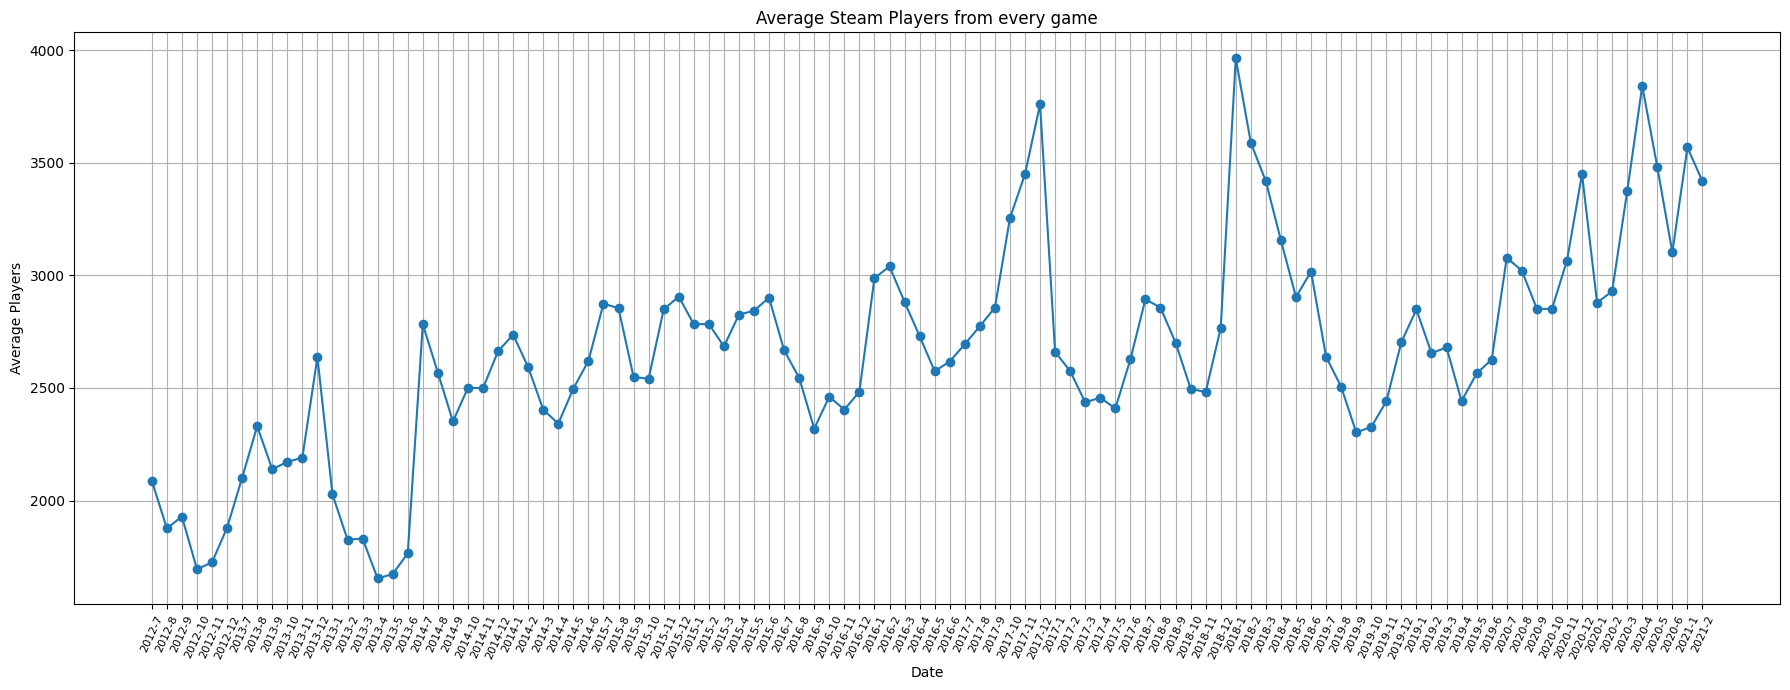

In [7]:
# Calculate monthly averages
monthly_avg = {}
for year in df_filtered['year'].unique():
    for month in df_filtered['month'].unique():
        monthly_data = df_filtered[(df_filtered['year'] == year) & (df_filtered['month'] == month)]
        if not monthly_data.empty:
            monthly_avg[f"{year}-{month}"] = monthly_data['avg'].mean()

# Plot
plt.figure(figsize=(18, 7))
plt.title("Average Steam Players from every game")
plt.xlabel('Date')
plt.ylabel('Average Players')
plt.plot(list(monthly_avg.keys()), list(monthly_avg.values()), marker='o')  # Plot monthly average
plt.xticks(rotation=65, fontsize=8)  # Rotate x-axis labels for better visibility
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Calculate monthly averages
monthly_avg = {}
for year in df_filtered['year'].unique():
    for month in df_filtered['month'].unique():
        monthly_data = df_filtered[(df_filtered['year'] == year) & (df_filtered['month'] == month)]
        if not monthly_data.empty:
            monthly_avg[f"{year}-{month}"] = monthly_data['avg'].mean()

# Create a DataFrame for monthly averages
df_monthly_avg = pd.DataFrame(list(monthly_avg.items()), columns=['date', 'monthly_avg'])
df_monthly_avg['date'] = pd.to_datetime(df_monthly_avg['date'])
df_monthly_avg.set_index('date', inplace=True)
df_monthly_avg.sort_index(inplace=True)

**Graphing the Rolling Mean & Standard Deviation**

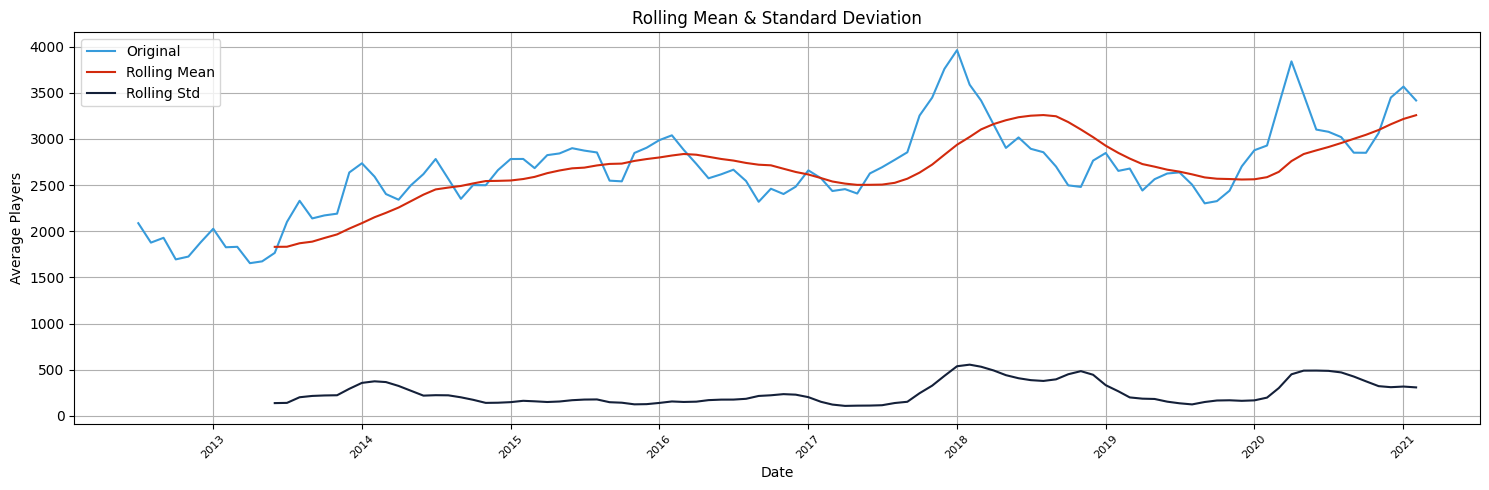

In [9]:
# Determine rolling statistics
# We use a rolling window of 12 to signify 12 months of the year, or yearly.
# This means we plot the mean and stdev at multiple given points throughout the graph for the data given.
df_monthly_avg["rolling_avg"] = df_monthly_avg["monthly_avg"].rolling(window=12).mean()
df_monthly_avg["rolling_std"] = df_monthly_avg["monthly_avg"].rolling(window=12).std()

# Plot rolling statistics
plt.figure(figsize=(15, 5))
plt.plot(df_monthly_avg["monthly_avg"], color='#379BDB', label='Original')
plt.plot(df_monthly_avg["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df_monthly_avg["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Average Players')
plt.xticks(rotation=45, fontsize=8)  # Rotate x-axis labels and set font size
plt.grid(True)
plt.tight_layout()
plt.show()

**Dickey-Fuller Test**

*   Getting statistics like p-value, test statistic, critical value, etc.

In [10]:
# Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df_monthly_avg["monthly_avg"], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -2.880604
p-value                          0.047650
#Lags Used                       1.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%)            -2.582122
dtype: float64


In [11]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df_monthly_avg["monthly_avg"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         m=12,
                         start_P=0,
                         seasonal=True, #set to seasonal
                         d=None,
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

**Using the SARIMA Model function.**

*   Standardized residual: data is better if it's more random
*   Histogram: to show data distribution and likelihood of finding different values
*   Normal Q-Q: shows normality
*   Correlogram: shows correlation between variables



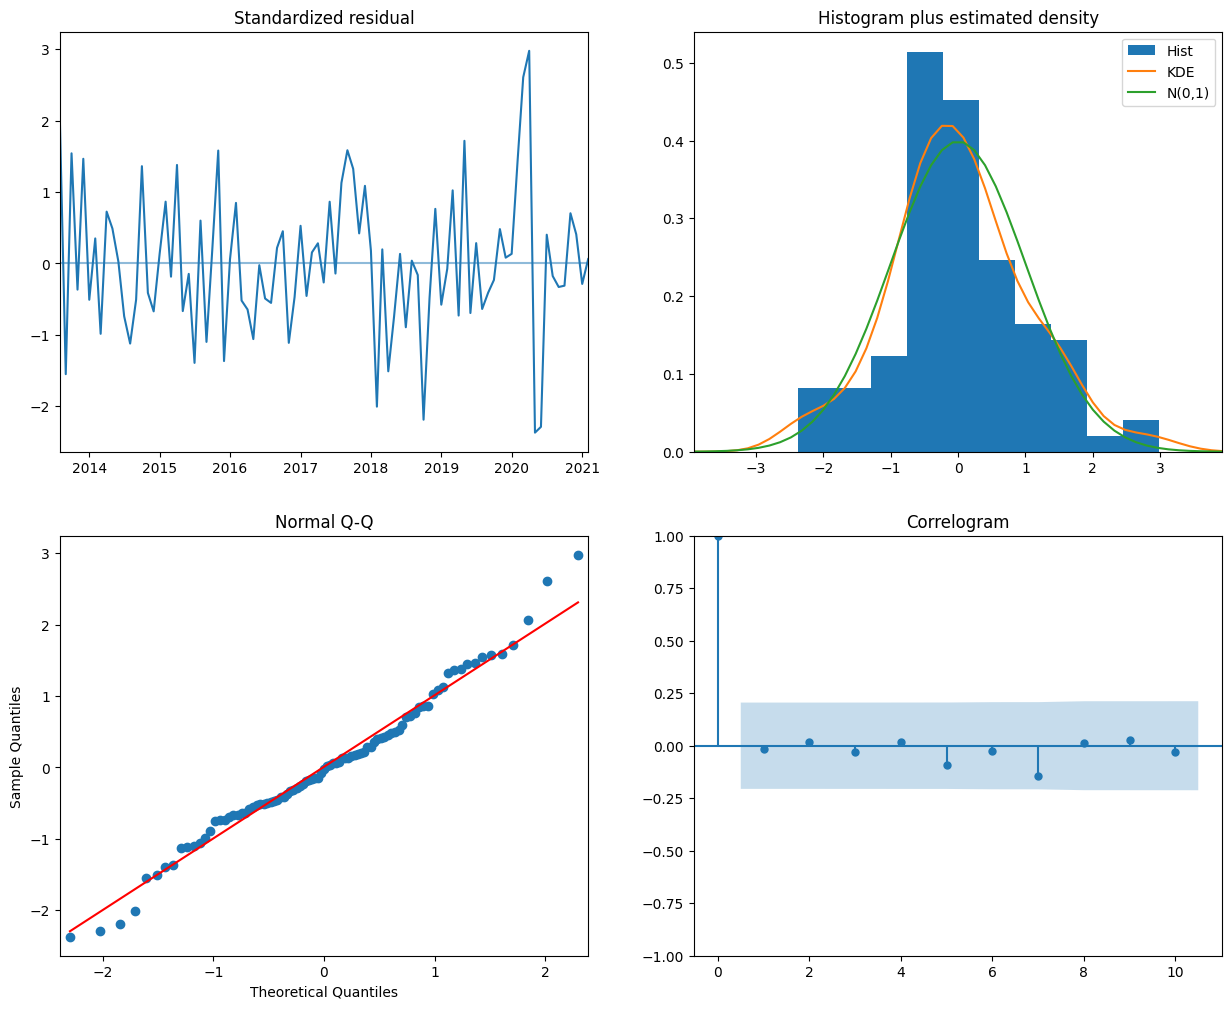

In [12]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

**Making the SARIMA Model**

*   Creating a Seasonal ARIMA model
*   Using monthly_avg as the main data point
*   seasonal=True for seasonal predictions





In [38]:
# Defining the index as the month.
df['month_index'] = df.index.month

# SARIMAX Model
SARIMAX_model = pm.auto_arima(df_monthly_avg[['monthly_avg']], exogenous=df[['month_index']], # Using the monthly average as the main variable of measure
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

**Graphing the forecast**

*   Defining the amount of periods (default is 24 months)
*   Large confidence interval due to 2018 player spike

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


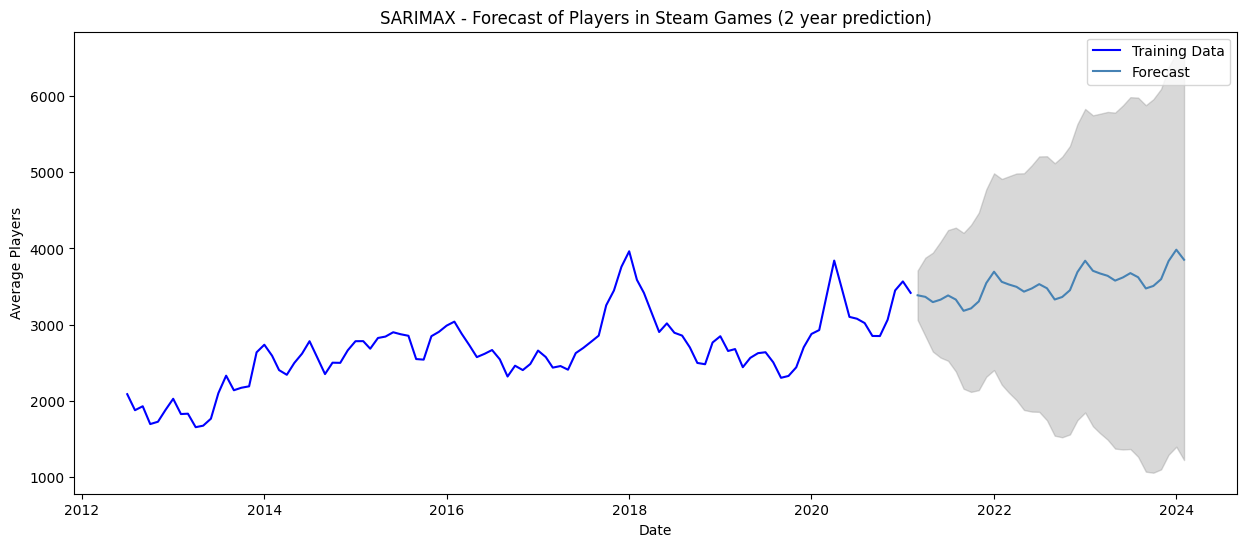

In [45]:
train_data = df_monthly_avg["monthly_avg"]  # Training data

exog_train = df['month_index']  # Exogenous variables for training

p = 1   # Autoregressive order (number of lagged observations)
d = 1   # Differencing order (number of differences for stationary time series)
q = 1   # Moving average order (number of lagged forecast errors)
P = 1   # Seasonal autoregressive order
D = 1   # Seasonal differencing order
Q = 1   # Seasonal moving average order
m = 12  # Seasonal period (period of seasons, aka a year)

SARIMAX_model = sm.tsa.SARIMAX(endog=train_data, exog=exog_train, order=(p, d, q), seasonal_order=(P, D, Q, m))

SARIMAX_results = SARIMAX_model.fit()

n_periods = 36  # Number of periods to forecast

# Create DataFrame for exogenous variables in the forecast period
forecast_df = pd.DataFrame({"month_index": pd.date_range(df.index[-1], periods=n_periods, freq='MS').month},
                            index=pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS'))

# Generate forecast
forecast = SARIMAX_results.get_forecast(steps=n_periods, exog=forecast_df[['month_index']])

# Get forecast values and confidence intervals
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(test_data, label='Training Data', color='blue')
plt.plot(forecast_values, label='Forecast', color='steelblue')
plt.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='gray', alpha=0.3)
plt.title('SARIMAX - Forecast of Players in Steam Games (2 year prediction)')
plt.xlabel('Date')
plt.ylabel('Average Players')
plt.legend()
plt.show()